<a href="https://colab.research.google.com/github/thiagomotax/Applied-Plotting-Charting-and-Data-Representation-in-Python/blob/master/Deep_learning_mypersonality_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Tentar equalizar a proporção de ocorrencia de cada label no dataset(balancear)
*   Tunar hiperparâmetros
*   Word cloud/similarity
*   Tentar usar pré-processamento do texto de várias bibliotecas (spacy, nltk, sklearn etc) para limpeza do texto (remover filters do keras tokenizer)
*   Salvar modelo ao finalizar
*   Tentar o dataset antigo usando data augmentation/data summarization
*   Tentar adicionar features no modelo (as que vem do dataset) pra ver se tem corelação com os traços
* Oversampling e undersimpling pra balancear os dados  imbalanced_learn that include SMOTE 
*   Verificar métricas pra multilabel/auc/recall/precision/matrix confusion 
*   Ver como o treino e a  validação estão sendo divididos e se estão sendo efetivamente usados
*  Tentar usar word embbeddings
*  Falar sobre a ativação, optimizer adm e binary crossentropy etc
*  https://www.kaggle.com/mutterberg/for-beginners-tackling-toxic-using-keras

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
# train = pd.read_csv('/content/drive/My Drive/tcc/datasets/mypersonality/train.csv')
# test = pd.read_csv('/content/drive/My Drive/tcc/datasets/mypersonality/test.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


df = pd.read_csv('/content/drive/My Drive/tcc/datasets/mypersonality/mypersonality_final.csv', encoding="ISO-8859-1")
df = df.drop(['#AUTHID',  'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS','DENSITY','BROKERAGE','NBROKERAGE','TRANSITIVITY'], axis = 1) 
df.cNEU.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cEXT.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cAGR.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cCON.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cOPN.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [4]:
#PRE-PROCCESS
#preproccess
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
newStopWords = ['propname', 'im', 'propnames' '1', '2', '3', '4', '5', '6', '7', '8', '9']
stop.extend(newStopWords)


df['STATUS'] = df['STATUS'].str.lower() #lowercase
df['STATUS'] = df['STATUS'].str.replace('[{}]'.format(string.punctuation), '') #pontuaction
df['STATUS'] = df['STATUS'].str.replace(r'\d+','') #num eros
df['STATUS'] = df['STATUS'].str.replace(' +', ' ') #this should replace all multiple spaces with a single space
df['STATUS'] = df['STATUS'].str.strip() #remove all spaces from the start and end
df['STATUS'] = df['STATUS'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop])) #stopwords

# df['STATUS'] = [x.replace("propnames", "") for x in df['STATUS']]
# df['STATUS'] = [x.replace("propname", "") for x in df['STATUS']]

df.replace("", np.nan, inplace=True) #empty lines to nan
df.dropna(how='any', inplace=True) #remove nan

#remover links
#remove empty registers
#minúscula
#acentuação / símbolos
#números
#stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#prepara a entrada pro EDA
label_cols = ["cEXT","cNEU","cAGR","cCON","cOPN"]
# df_text_traits['one_hot_labels'] = list(df_text_traits[label_cols].values)
df['one_hot_labels'] = df['cEXT'].map(str) + df['cNEU'].map(str) + df['cAGR'].map(str) + df['cCON'].map(str) + df['cOPN'].map(str)
df = df.drop(["cEXT","cNEU","cAGR","cCON","cOPN"], axis=1)
frame = df[['one_hot_labels', 'STATUS']]
frame.to_csv('input_mypersonalityEDA.txt', header=False, index=False, sep='\t', mode='a')
#processa no pc local 

In [6]:
#recebe a entrada processada pelo EDA
import re
new_df = pd.read_csv('/content/output_mypersonalityEDA.txt', names=['content'], sep="\f", header=None)
rows_list = []
for index, row in new_df.iterrows():
  props = re.split(r'\t+', row['content'])
  cEXT = props[0][0]
  cNEU = props[0][1]
  cAGR = props[0][2]
  cCON = props[0][3]
  cOPN = props[0][4]
  STATUS = props[1]
  dataTemp = {}
  dataTemp.update({'cEXT':cEXT, 'cNEU':cNEU, 'cAGR':cAGR, 'cCON':cCON, 'cOPN':cOPN, 'STATUS':STATUS})
  rows_list.append(dataTemp)

df = pd.DataFrame(rows_list, columns=["cEXT","cNEU","cAGR","cCON","cOPN", "STATUS"])

In [7]:
df.STATUS = df.STATUS.astype(str)

In [ ]:
#df.STATUS

In [ ]:
#df.info()


In [9]:
from sklearn.model_selection import train_test_split
list_classes = ["cEXT","cNEU","cAGR","cCON","cOPN"]
train, test = train_test_split(df, random_state=42, test_size=0.10, shuffle=True)

list_sentences_train = train.STATUS
list_sentences_test = test.STATUS

y_train = train[list_classes].values
y_test = test[list_classes].values

In [10]:
max_features = 5000 
#By default, all punctuation is removed, turning the texts into space-separated sequences of words

tokenizer = Tokenizer(num_words=max_features, lower=True, filters='') #Only the most common num_words-1 will kept 
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [11]:
# What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:
# Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
# Comment #2: [1,2]
maxlen = 20
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [12]:
import numpy as np
import gc

In [13]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='/content/drive/MyDrive/tcc/glove.6B.200d.txt'
            embed_size = 200
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [14]:
embedding_matrix = loadEmbeddingMatrix('glove')


Loaded 400000 word vectors.
total embedded: 15738 common words


In [15]:
embedding_matrix.shape


(19720, 200)

In [16]:
#We begin our defining an   
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [17]:
#default comented
#embed_size = 128
#x = Embedding(max_features, embed_size)(inp)

x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

#default
#x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

x = GlobalMaxPool1D()(x)



x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)

# - 1 ou +1 (4)
x = Dense(5, activation="sigmoid")(x)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
from keras.callbacks import ModelCheckpoint

#filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
batch_size = 32 #refere-se ao número de exemplos de treinamento usados em uma iteração.
epochs = 500
history = model.fit(
    X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.15
    )


Train on 37725 samples, validate on 6658 samples
Epoch 1/500
 5856/37725 [===>..........................] - ETA: 31s - loss: 0.3456 - accuracy: 0.8409 - precision: 0.8337 - auc: 0.9101 - recall: 0.8055

KeyboardInterrupt: ignored

In [ ]:
y_train

In [ ]:
'python --version'

In [ ]:
#Um modelo cujas previsões estão 100% erradas tem uma AUC de 0, enquanto um modelo cujas previsões são 100% corretas tem uma AUC de 1.

In [ ]:
# score = model.evaluate(X_test, y_test)
# print("\n Testing Accuracy:", score[1])
# # print("\n Cat Accuracy:", score[2])

In [26]:
#word count
x = sorted((tokenizer.word_index).items(), key=lambda x: x[1], reverse=True)
x

[('spark', 19720),
 ('motility', 19719),
 ('respectable', 19718),
 ('lei', 19717),
 ('overjealous', 19716),
 ('kingmaker', 19715),
 ('noneffervescent', 19714),
 ('trolling', 19713),
 ('limon', 19712),
 ('bilk', 19711),
 ('damned', 19710),
 ('compare', 19709),
 ('won', 19708),
 ('endowed', 19707),
 ('townsfolk', 19706),
 ('disgust', 19705),
 ('calfskin', 19704),
 ('lir', 19703),
 ('rico', 19702),
 ('puerto', 19701),
 ('gainsay', 19700),
 ('annulus', 19699),
 ('promenade', 19698),
 ('pageant', 19697),
 ('unsubdivided', 19696),
 ('organised', 19695),
 ('slacken', 19694),
 ('misrepresentation', 19693),
 ('aerate', 19692),
 ('postponement', 19691),
 ('reinforced', 19690),
 ('nonvoluntary', 19689),
 ('speculation', 19688),
 ('milan', 19687),
 ('patronise', 19686),
 ('rater', 19685),
 ('grille', 19684),
 ('intimately', 19683),
 ('gmt', 19682),
 ('appreciation', 19681),
 ('precise', 19680),
 ('lacking', 19679),
 ('reposition', 19678),
 ('cony', 19677),
 ('prioritise', 19676),
 ('camomile', 196

Text(0.5, 0, 'fator')

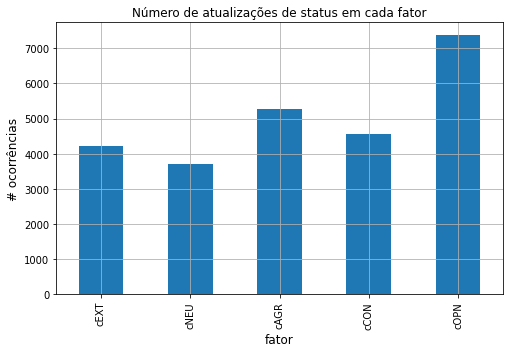

In [ ]:
counts = []
df_status = df.drop(['STATUS'], axis=1)
categories = list(df_status.columns.values)
for i in categories:
    counts.append((i, df_status[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])

df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Número de atualizações de status em cada fator")
plt.ylabel('# ocorrências', fontsize=12)
plt.xlabel('fator', fontsize=12)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# de fatores')

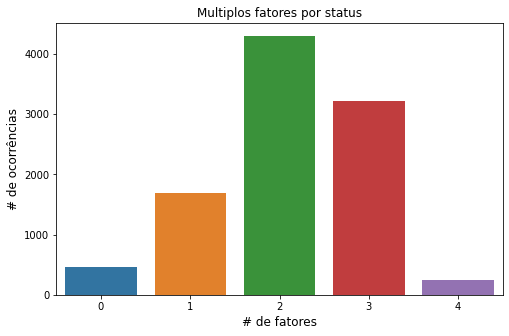

In [ ]:
import seaborn as sns

rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiplos fatores por status")
plt.ylabel('# de ocorrências', fontsize=12)
plt.xlabel('# de fatores', fontsize=12)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

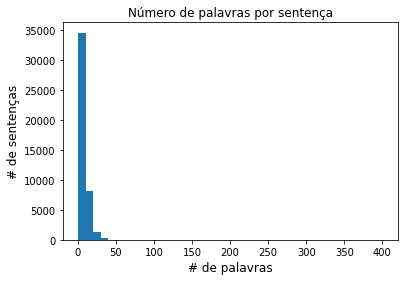

In [ ]:
#As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, 
#but I'm being paranoid so I have set to 200. 
#Then again, it sounds like something you could experiment and see what is the magic number.
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])´
plt.title("Número de palavras por sentença")
plt.ylabel('# de sentenças', fontsize=12)
plt.xlabel('# de palavras', fontsize=12)
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.update(["propname"])

text = " ".join(review for review in df['STATUS'])

wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

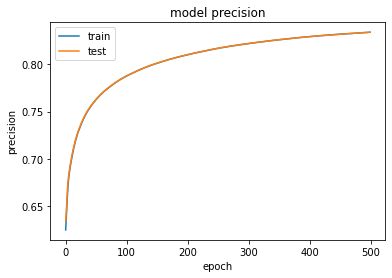

In [27]:
import matplotlib.pyplot as plt

# #accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()


# #loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

# #auc
# plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])

# plt.title('model auc')
# plt.ylabel('auc')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

#precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# #recall
# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])

# plt.title('model recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

In [34]:
# from keras.models import load_model
# model.save("model.h5")
saved_model = load_model('model.h5')

ValueError: ignored

In [ ]:
#df

In [ ]:
traits_labels = df[["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]]


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

traits_labels.sum(axis=0).plot.bar()

In [ ]:
predictions = model.predict(np.expand_dims(X_test[500], 0))

print(tokenizer.sequences_to_texts([X_test[500]]))
print(y_test[500])
print(predictions)

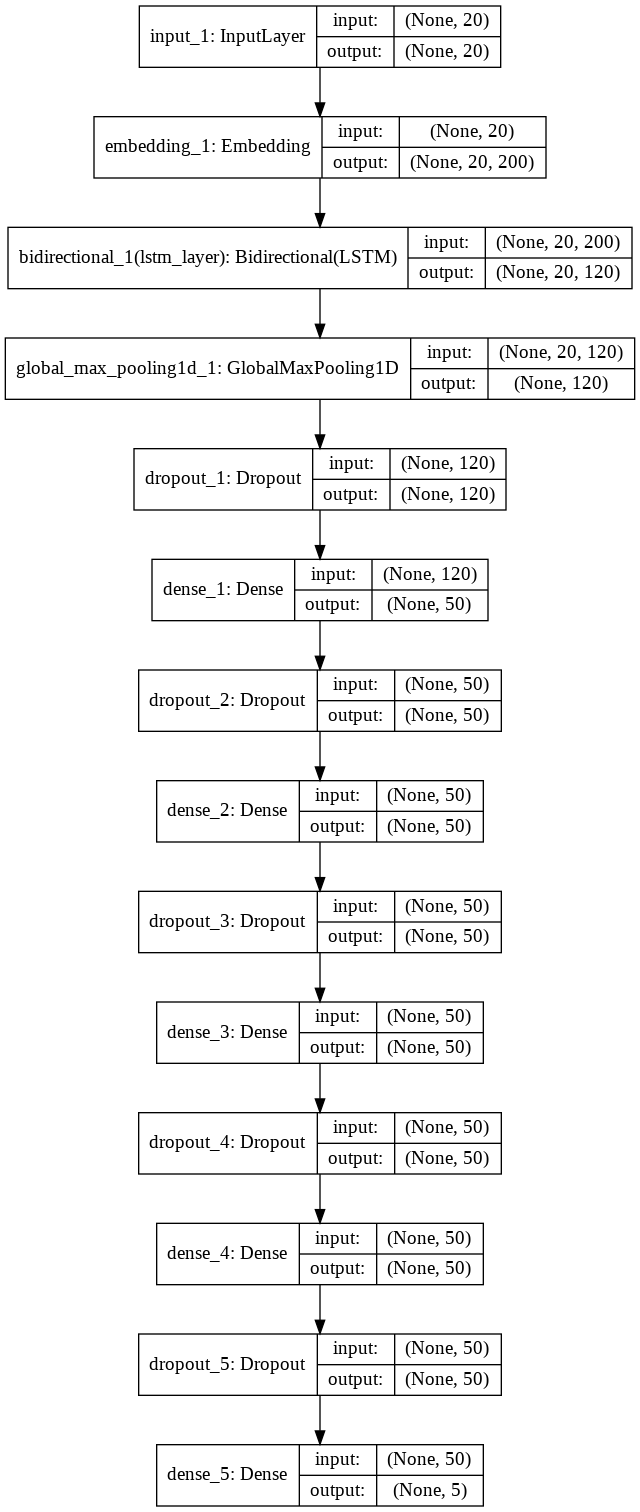

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
#One possibility: If you are using dropout regularization layer in your network, it is reasonable that the validation error is smaller than training error. Because usually dropout is activated when training but deactivated when evaluating on the validation set. You get a more smooth (usually means better) function in the latter case.